In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Load the dataset
file_path = './datasets/diabetes.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
print("First few rows of the dataset:")
print(data.head())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Display basic statistics for the dataset
print("\nBasic statistics of the dataset:")
print(data.describe())

# Impute missing values (represented as zeros) using the median of each column
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN in the specified columns
for column in columns_to_impute:
    data[column] = data[column].replace(0, np.nan)

# Impute using the median
for column in columns_to_impute:
    median_value = data[column].median()
    data[column].fillna(median_value, inplace=True)

# Verify the changes
print("\nStatistics after imputation:")
print(data.describe())

# Separate the features (X) from the target (y)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Combine X and y for resampling
data_combined = pd.concat([X, y], axis=1)

'''
# Separate majority and minority classes
majority_class = data_combined[data_combined.Outcome == 0]
minority_class = data_combined[data_combined.Outcome == 1]

# Upsample minority class
minority_class_upsampled = resample(minority_class, 
                                    replace=True,     # sample with replacement
                                    n_samples=len(majority_class),    # to match majority class
                                    random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
balanced_data = pd.concat([majority_class, minority_class_upsampled])

# Separate the balanced data into features and target
X_balanced = balanced_data.drop(columns=['Outcome'])
y_balanced = balanced_data['Outcome']
'''

# Split the balanced data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reset indices of the feature and target DataFrames
X_train_df = X_train.reset_index(drop=True)
X_val_df = X_val.reset_index(drop=True)
X_test_df = X_test.reset_index(drop=True)

y_train_df = y_train.reset_index(drop=True)
y_val_df = y_val.reset_index(drop=True)
y_test_df = y_test.reset_index(drop=True)

# Combine the feature DataFrames with their corresponding target variables
train_data = pd.concat([X_train_df, y_train_df], axis=1)
val_data = pd.concat([X_val_df, y_val_df], axis=1)
test_data = pd.concat([X_test_df, y_test_df], axis=1)

# Save the datasets as CSV files
train_data.to_csv('./datasets/train_data_balanced.csv', index=False)
val_data.to_csv('./datasets/val_data_balanced.csv', index=False)
test_data.to_csv('./datasets/test_data_balanced.csv', index=False)


First few rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0


C:\Users\lyna\AppData\Local\Temp\ipykernel_9168\3498357648.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(median_value, inplace=True)


In [2]:
import xgboost as xgb
import pickle
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    log_loss, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report
)

# Create a DMatrix for training, validation, and test data
# DMatrix is an optimized data structure that XGBoost uses to train and predict
dtrain = xgb.DMatrix(data=X_train.to_numpy(), label=y_train)
dval = xgb.DMatrix(data=X_val.to_numpy(), label=y_val)
dtest = xgb.DMatrix(data=X_test.to_numpy(), label=y_test)

# Set the hyperparameters for the XGBoost model
params = {
    "colsample_bytree": 0.8247176589617523, 
    "gamma": 0.30255939244569324, 
    "learning_rate": 0.07102942639067696, 
    "max_depth": 9, 
    "subsample": 0.8171213407907597, 
    "eval_metric": "auc"
}

# Number of boosting rounds
num_round = 100

# Train the model with the best parameters
evallist = [(dval, 'eval')]  # Evaluation set
bst = xgb.train(params, dtrain, num_round, evals=evallist, early_stopping_rounds=10)

# Evaluate the model on the test set
preds = bst.predict(dtest)  # Predict probabilities
predictions = [round(value) for value in preds]  # Convert probabilities to binary predictions

# Calculate basic evaluation metrics
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, preds)
logloss = log_loss(y_test, preds)

# Print basic evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

# Calculate evaluation metrics per class
precision_class_0 = precision_score(y_test, predictions, pos_label=0)
recall_class_0 = recall_score(y_test, predictions, pos_label=0)
f1_class_0 = f1_score(y_test, predictions, pos_label=0)

precision_class_1 = precision_score(y_test, predictions, pos_label=1)
recall_class_1 = recall_score(y_test, predictions, pos_label=1)
f1_class_1 = f1_score(y_test, predictions, pos_label=1)

# Generate the classification report
classification_report_output = classification_report(y_test, predictions)

# Display all evaluation results
results = {
    'Precision_Class_0': precision_class_0,
    'Recall_Class_0': recall_class_0,
    'F1_Score_Class_0': f1_class_0,
    'Precision_Class_1': precision_class_1,
    'Recall_Class_1': recall_class_1,
    'F1_Score_Class_1': f1_class_1,
    'ROC_AUC': roc_auc,
    'Classification_Report': classification_report_output
}

print(results)

# Save the model in JSON format
bst.save_model('./models/diabetes_xgb_model_proofs.json')
print("Model saved in JSON format successfully!")

# Save the model using pickle
with open('./models/diabetes_xgb_model_proofs.pkl', 'wb') as f:
    pickle.dump(bst, f)
print("Model saved using pickle successfully!")


[0]	eval-auc:0.60672
[1]	eval-auc:0.69491
[2]	eval-auc:0.74619
[3]	eval-auc:0.74567
[4]	eval-auc:0.71674
[5]	eval-auc:0.72973
[6]	eval-auc:0.73319
[7]	eval-auc:0.74809
[8]	eval-auc:0.75260
[9]	eval-auc:0.75953
[10]	eval-auc:0.75641
[11]	eval-auc:0.75710
[12]	eval-auc:0.75780
[13]	eval-auc:0.76369
[14]	eval-auc:0.76057
[15]	eval-auc:0.76611
[16]	eval-auc:0.77477
[17]	eval-auc:0.77235
[18]	eval-auc:0.77581
[19]	eval-auc:0.77720
[20]	eval-auc:0.77963
[21]	eval-auc:0.78240
[22]	eval-auc:0.78413
[23]	eval-auc:0.78552
[24]	eval-auc:0.78482
[25]	eval-auc:0.78448
[26]	eval-auc:0.78344
[27]	eval-auc:0.78413
[28]	eval-auc:0.78621
[29]	eval-auc:0.78621
[30]	eval-auc:0.78552
[31]	eval-auc:0.78760
[32]	eval-auc:0.78725
[33]	eval-auc:0.78725
[34]	eval-auc:0.78863
[35]	eval-auc:0.78863
[36]	eval-auc:0.78829
[37]	eval-auc:0.78863
[38]	eval-auc:0.78967
[39]	eval-auc:0.79106
[40]	eval-auc:0.79106
[41]	eval-auc:0.79106
[42]	eval-auc:0.79106
[43]	eval-auc:0.79175
[44]	eval-auc:0.79175
[45]	eval-auc:0.7917

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle

# Load the model
with open('./models/diabetes_xgb_model_proofs.pkl', 'rb') as f:
    bst = pickle.load(f)

# Function to simulate covariate shift by adding realistic small noise
def simulate_covariate_shift(X, shift_levels, shift_features=None):
    np.random.seed(0)
    
    if shift_features is None:
        shift_features = X.columns
    
    shifted_datasets = {}  # To store datasets with different shift levels
    
    for level in shift_levels:
        X_shifted = X.copy()
        for feature in shift_features:
            # Calculate a small shift as a fraction of the feature's standard deviation
            feature_std = X[feature].std()
            shift = np.random.normal(loc=0, scale=level * feature_std, size=X[feature].shape)
            X_shifted[feature] += shift
        
        shifted_datasets[level] = X_shifted
    
    return shifted_datasets

# Select features to shift (for example, 'Glucose', 'BMI', 'DiabetesPedigreeFunction')
shift_features = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']

# Define smaller, more realistic shift levels (fractions of the standard deviation)
small_shift_levels = [0.1, 0.2, 0.3, 0.5, 1, 2, 3]

# Simulate covariate shift on the test set
shifted_datasets = simulate_covariate_shift(pd.DataFrame(X_test, columns=X.columns), shift_levels=small_shift_levels, shift_features=shift_features)

# Loop through each shifted dataset and evaluate the model
results = []

for level, X_test_shifted in shifted_datasets.items():
    # Save the shifted test set as a CSV file
    X_test_shifted_df = pd.DataFrame(X_test_shifted, columns=X.columns).reset_index(drop=True)
    y_shifted_df = y_test.reset_index(drop=True)
    
    shifted_data = pd.concat([X_test_shifted_df, y_shifted_df], axis=1)
    shifted_data.to_csv(f'./datasets/test_data_shifted_level_{level}_realistic.csv', index=False)
    
    # Evaluate the model on the shifted test set
    dtest_shifted = xgb.DMatrix(data=X_test_shifted, label=y_test)
    preds_shifted = bst.predict(dtest_shifted)
    predictions_shifted = [round(value) for value in preds_shifted]
    
    # Calculate evaluation metrics for the shifted test set
    accuracy_shifted = accuracy_score(y_test, predictions_shifted)
    roc_auc_shifted = roc_auc_score(y_test, preds_shifted)
    logloss_shifted = log_loss(y_test, preds_shifted)
    
    # Store the results
    results.append({
        'shift_level': level,
        'accuracy': accuracy_shifted,
        'roc_auc': roc_auc_shifted,
        'log_loss': logloss_shifted
    })

# Convert the results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)


   shift_level  accuracy   roc_auc  log_loss
0          0.1  0.758621  0.808780  0.507814
1          0.2  0.741379  0.848455  0.474412
2          0.3  0.732759  0.804228  0.523355
3          0.5  0.750000  0.817886  0.499490
4          1.0  0.758621  0.752846  0.549040
5          2.0  0.698276  0.763902  0.555878
6          3.0  0.663793  0.638211  0.721501


C:\Users\lyna\AppData\Local\Temp\ipykernel_1784\2237951618.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original[feature], label='Original', color='green', shade=True)
C:\Users\lyna\AppData\Local\Temp\ipykernel_1784\2237951618.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(shifted_0_5[feature], label='Shift Intensity Level 0.5', color='#FFD700', shade=True)     # Red
C:\Users\lyna\AppData\Local\Temp\ipykernel_1784\2237951618.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(shifted_1[feature], label='Shift Intensity Level 1', color='#DAA520', shade=True)  # Light Yellow
C:\Users\lyna\AppData\Local\Temp\i

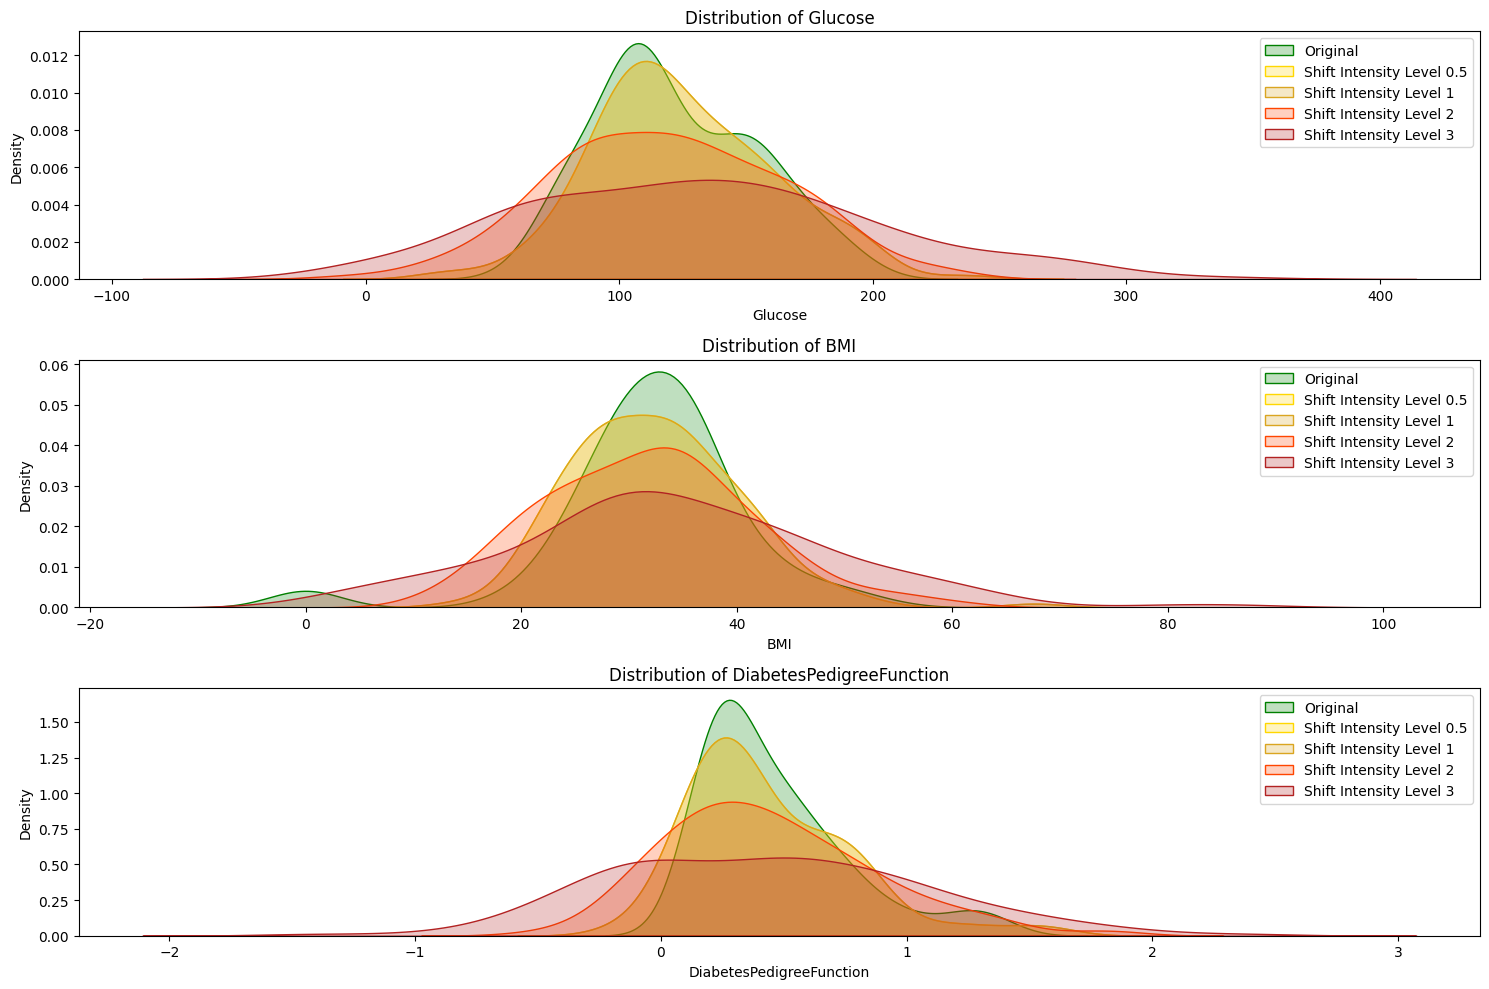

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original and shifted datasets from CSV files
original_data = pd.read_csv('./datasets/test_data_not_scaled.csv')
shifted_0_1 = pd.read_csv('./datasets/test_data_shifted_level_0.1_unscaled.csv')
shifted_0_2 = pd.read_csv('./datasets/test_data_shifted_level_0.2_unscaled.csv')
shifted_0_5 = pd.read_csv('./datasets/test_data_shifted_level_0.5_unscaled.csv')
shifted_1 = pd.read_csv('./datasets/test_data_shifted_level_1_unscaled.csv')
shifted_2 = pd.read_csv('./datasets/test_data_shifted_level_2_unscaled.csv')
shifted_3 = pd.read_csv('./datasets/test_data_shifted_level_3_unscaled.csv')


# Plotting function
def plot_feature_distributions_from_csv(original, shifted_1, shifted_2, shifted_3, shifted_4, features):
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        
        sns.kdeplot(original[feature], label='Original', color='green', shade=True)
        sns.kdeplot(shifted_0_1[feature], label='Shift Intensity Level 0.1', color='#FFD700', shade=True)     # Red
        sns.kdeplot(shifted_0_2[feature], label='Shift Intensity Level 0.2', color='#FFD700', shade=True)     # Red
        sns.kdeplot(shifted_0_5[feature], label='Shift Intensity Level 0.5', color='#FFD700', shade=True)     # Red
        sns.kdeplot(shifted_1[feature], label='Shift Intensity Level 1', color='#DAA520', shade=True)  # Light Yellow
        sns.kdeplot(shifted_2[feature], label='Shift Intensity Level 2', color='#FF4500', shade=True)  # Orange
        sns.kdeplot(shifted_3[feature], label='Shift Intensity Level 3', color='#B22222', shade=True)  # Dark Orange
        
        
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function with the features you want to compare
shift_features = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']
plot_feature_distributions_from_csv(original_data, shifted_0_5, shifted_1, shifted_2, shifted_3, shift_features)


In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from pprint import pprint
from MED3pa.datasets import DatasetsManager
from MED3pa.models import BaseModelManager, ModelFactory
from MED3pa.detectron import DetectronExperiment, MannWhitneyStrategy, OriginalDisagreementStrategy, EnhancedDisagreementStrategy, DetectronRecordsManager
import pandas as pd
import numpy as np 

# Define different magnitudes of covariate shift to evaluate
shift_magnitudes = [0.001, 0.003, 0.005, 0.01]

# Loop through each shift magnitude, read the shifted dataset, and execute Detectron experiment
for level in shift_magnitudes:

    datasets = DatasetsManager()
    datasets.set_from_file("training", "./datasets/train_data_balanced.csv", "Outcome")
    datasets.set_from_file("validation", "./datasets/val_data_balanced.csv", "Outcome")
    datasets.set_from_file("reference", "./datasets/test_data_balanced.csv", "Outcome")
    
    # Load the shifted test set
    shifted_test_file = f'./datasets/test_data_shifted_level_{level}_unscaled.csv'
    datasets.set_from_file("testing", shifted_test_file, "Outcome")
    detectron_path = f'./results/detectron_experiment_{level}'

    factory = ModelFactory()
    loaded_model = factory.create_model_from_pickled("./models/diabetes_xgb_model_proofs.pkl")

    bm_manager = BaseModelManager()
    bm_manager.set_base_model(loaded_model) 

    # Run Detectron experiment
    detectron_results = DetectronExperiment.run(datasets=datasets, base_model_manager=bm_manager)
    # Print and store the results
    print(f"Results for shift magnitude: {level}")
    pprint(detectron_results.analyze_results(['original_disagreement_strategy', 'mannwhitney_strategy', 'enhanced_disagreement_strategy']))
    detectron_results.save(detectron_path)

    BaseModelManager.reset()



running seeds: 100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 0.001
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 16.28,
  'baseline_std': 1.929144888285999,
  'p_value': 0.02,
  'test_statistic': 12},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 0.0010488295071904834,
  'significance_description': {'large': 8.88888888888889,
                               'moderate': 25.555555555555554,
                               'small': 35.55555555555556,
                               'unsignificant shift': 30.0},
  'u_statistic': 2997.0},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 3.6666666666666665,
  'baseline_std': 1.7191729277636836,
  'shift_probability': 0.6777777777777778,
  'significance_description': {'large': 8.88888888888889,
                               'moderate': 25.555555555555554,
                               'small': 35.55555555555556,
                               'unsignificant shift': 30.0},
  'test_statis

running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 0.003
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 16.28,
  'baseline_std': 1.929144888285999,
  'p_value': 0.0,
  'test_statistic': 10},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 6.127319541596578e-05,
  'significance_description': {'large': 16.666666666666664,
                               'moderate': 18.88888888888889,
                               'small': 34.44444444444444,
                               'unsignificant shift': 30.0},
  'u_statistic': 2728.0},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 3.6666666666666665,
  'baseline_std': 1.7191729277636836,
  'shift_probability': 0.6777777777777778,
  'significance_description': {'large': 16.666666666666664,
                               'moderate': 18.88888888888889,
                               'small': 34.44444444444444,
                               'unsignificant shift': 30.0},
  'test_stati

running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 0.005
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 16.28,
  'baseline_std': 1.929144888285999,
  'p_value': 0.0,
  'test_statistic': 11},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 0.0002752494773445424,
  'significance_description': {'large': 11.11111111111111,
                               'moderate': 24.444444444444443,
                               'small': 25.555555555555554,
                               'unsignificant shift': 38.88888888888889},
  'u_statistic': 2861.5},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 3.6666666666666665,
  'baseline_std': 1.7191729277636836,
  'shift_probability': 0.6777777777777778,
  'significance_description': {'large': 11.11111111111111,
                               'moderate': 24.444444444444443,
                               'small': 25.555555555555554,
                               'unsignificant shift': 38.88

running seeds: 100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


Detectron execution on reference set completed.


running seeds: 100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Detectron execution on testing set completed.
Results for shift magnitude: 0.01
[{'Strategy': 'original_disagreement_strategy',
  'baseline_mean': 16.28,
  'baseline_std': 1.929144888285999,
  'p_value': 0.02,
  'test_statistic': 12},
 {'Strategy': 'mannwhitney_strategy',
  'p_value': 2.2502327502926124e-05,
  'significance_description': {'large': 10.0,
                               'moderate': 22.22222222222222,
                               'small': 38.88888888888889,
                               'unsignificant shift': 28.888888888888886},
  'u_statistic': 2644.5},
 {'Strategy': 'enhanced_disagreement_strategy',
  'baseline_mean': 3.6666666666666665,
  'baseline_std': 1.7191729277636836,
  'shift_probability': 0.6777777777777778,
  'significance_description': {'large': 10.0,
                               'moderate': 22.22222222222222,
                               'small': 38.88888888888889,
                               'unsignificant shift': 28.888888888888886},
  'test_stat